In [1]:
import CairoMakie
import CSV
import FASTX
import HDF5
import Infernal
import KernelDensity
import Makie
import RestrictedBoltzmannMachines as RBMs
import Rfam
import SamApp
import StatsBase
import ViennaRNA
import ViennaRNA_jll
using BioSequences: LongRNA
using DataFrames: DataFrame
using Distributions: Gamma
using Distributions: logpdf
using Distributions: pdf
using Distributions: Poisson
using LinearAlgebra: Diagonal
using LinearAlgebra: eigen
using Makie: @L_str
using NaNStatistics: nanmean
using NaNStatistics: nansum
using ProgressMeter: @showprogress
using Random: bitrand
using RestrictedBoltzmannMachines: free_energy
using Statistics: cor
using Statistics: mean
using Statistics: middle
using StatsBase: countmap
using Unitful: ustrip

In [2]:
@show Rfam.get_rfam_directory();
@show Rfam.get_rfam_version();

Rfam.get_rfam_directory() = "/home/vscode/data/Rfam"
Rfam.get_rfam_version() = "14.7"


In [3]:
# load SHAPE data
shape_data_045 = SamApp.load_shapemapper_data_pierre_demux_20230920(; demux=true);

# split rep0 from rep4+5
shape_data_rep0 = SamApp.select_conditions_20231002(shape_data_045, filter(endswith("_rep0"), shape_data_045.conditions));
shape_data_rep45 = SamApp.select_conditions_20231002(shape_data_045, filter(endswith("_rep45"), shape_data_045.conditions));

In [19]:
conds_sam_rep0 = identity.(indexin(["SAMAP_1M7_0-1SAM_5Mg_T30C_rep0", "SAMAP_1M7_0-5SAM_5Mg_T30C_rep0", "SAMAP_1M7_1SAM_5Mg_T30C_rep0"], shape_data_rep0.conditions));
conds_mg_rep0 = identity.(indexin(["SAMAP_1M7_noSAM_5Mg_T30C_rep0"], shape_data_rep0.conditions));
conds_30C_rep0 = identity.(indexin(["SAMAP_1M7_noSAM_noMg_T30C_rep0"], shape_data_rep0.conditions));

conds_sam_rep45 = identity.(indexin(["SAMAP_1M7_0-1SAM_5Mg_T30C_rep45", "SAMAP_1M7_1SAM_5Mg_T30C_rep45"], shape_data_rep45.conditions));
conds_mg_rep45 = identity.(indexin(["SAMAP_1M7_noSAM_5Mg_T30C_rep45"], shape_data_rep45.conditions));
conds_30C_rep45 = identity.(indexin(["SAMAP_1M7_noSAM_noMg_T30C_rep45"], shape_data_rep45.conditions));

@show conds_sam_rep0 conds_mg_rep0 conds_30C_rep0;
@show conds_sam_rep45 conds_mg_rep45 conds_30C_rep45;

conds_sam_rep0 = [1, 2, 3]
conds_mg_rep0 = [4]
conds_30C_rep0 = [5]
conds_sam_rep45 = [1, 2]
conds_mg_rep45 = [4]
conds_30C_rep45 = [6]


In [20]:
(; bps, nps, pks) = SamApp.RF00162_sites_paired()

(bps = [1, 2, 3, 4, 5, 6, 7, 8, 13, 14  …  97, 100, 101, 102, 103, 104, 105, 106, 107, 108], nps = [9, 10, 11, 12, 18, 19, 20, 24, 32, 33  …  73, 74, 75, 87, 88, 89, 90, 91, 98, 99], pks = [25, 26, 27, 28, 77, 78, 79, 80])

In [21]:
rbm_seqs = findall(shape_data_045.aptamer_origin .== "RF00162_syn_rbm")
inf_seqs = findall(shape_data_045.aptamer_origin .== "RF00162_syn_inf")
full_seqs = findall(shape_data_045.aptamer_origin .== "RF00162_full30")
seed_seqs = findall(shape_data_045.aptamer_origin .== "RF00162_seed70")
nat_seqs = full_seqs ∪ seed_seqs;

In [22]:
bps_reactivities_rep0 = shape_data_rep0.shape_reactivities[bps, nat_seqs, conds_sam_rep0];
nps_reactivities_rep0 = shape_data_rep0.shape_reactivities[nps, nat_seqs, conds_sam_rep0];
all_reactivities_rep0 = shape_data_rep0.shape_reactivities[:, nat_seqs, conds_sam_rep0];

shape_stats_rep0 = SamApp.shape_basepair_log_odds_v4(;
    shape_data = shape_data_rep0,
    paired_reactivities = bps_reactivities_rep0,
    unpaired_reactivities = nps_reactivities_rep0,
    all_reactivities = all_reactivities_rep0,
    only_hq_profile = true, p_thresh = 1e-3, nsamples = 1000
);

In [23]:
_thresh = log(5)

1.6094379124341003

In [24]:
_sites = SamApp.hallmark_sites_20230507;

In [51]:
x_mg_rep0 = nansum(shape_stats_rep0.shape_log_odds[_sites, :,  conds_mg_rep0]; dim=(1,3))
x_sam_rep0 = nansum(shape_stats_rep0.shape_log_odds[_sites, :, conds_sam_rep0]; dim=(1,3))

_responds_sam_yes_rep0 = (x_mg_rep0 .< -_thresh) .& (x_sam_rep0 .> +_thresh);
_responds_sam_nop_rep0 = (x_mg_rep0 .> +_thresh) .| (x_sam_rep0 .< -_thresh);
_inconclusive_rep0 = ((!).(_responds_sam_yes_rep0)) .& ((!).(_responds_sam_nop_rep0));
_conclusive_rep0 = _responds_sam_yes_rep0 .| _responds_sam_nop_rep0;

sum(_responds_sam_yes_rep0)

111

In [14]:
aptamer_rbm_energies = [
    ismissing(seq) ? missing : 
    free_energy(SamApp.rbm2022(), SamApp.onehot(LongRNA{4}(seq)))
    for seq in shape_data_045.aligned_sequences
];

In [15]:
wuss = SamApp.rfam_ss("RF00162"; inserts=false)
ss = SamApp.clean_wuss(wuss)

"((((((((....(((((...(((.....)))......)))))((((.((((((.......))))..))))))...(....((((((.....))))))..)))))))))"

In [16]:
p1_pos = SamApp.RF00162_sites_annotated_secondary_structure().p1;
p2_pos = SamApp.RF00162_sites_annotated_secondary_structure().p2;
p3_pos = SamApp.RF00162_sites_annotated_secondary_structure().p3;
p4_pos = SamApp.RF00162_sites_annotated_secondary_structure().p4;
pk_pos = SamApp.RF00162_sites_annotated_secondary_structure().pk;

In [17]:
ss_without_P1 = join([i ∈ p1_pos ? '.' : c for (i,c) in enumerate(ss)]);
ss_without_P2 = join([i ∈ p2_pos ? '.' : c for (i,c) in enumerate(ss)]);
ss_without_P3 = join([i ∈ p3_pos ? '.' : c for (i,c) in enumerate(ss)]);
ss_without_P4 = join([i ∈ p4_pos ? '.' : c for (i,c) in enumerate(ss)]);

In [18]:
ss_pk_only = replace(wuss, r"\(|\)|\[|\]|\{|\}|\<|\>|\-|\_|\," => '.', 'A' => '(', 'a' => ')')

"........................((((................................................))))............................"

In [19]:
sampled_v = SamApp.rbm2022samples();

In [20]:
Vienna_energies_fold = [ismissing(seq) ? missing : ustrip(ViennaRNA.energy(string(seq), ss)) for seq = shape_data_rep0.aligned_sequences];
Vienna_energies_P1 = [ismissing(seq) ? missing : ustrip(ViennaRNA.energy(string(seq), ss)) - ustrip(ViennaRNA.energy(string(seq), ss_without_P1)) for seq = shape_data_rep0.aligned_sequences];
Vienna_energies_P2 = [ismissing(seq) ? missing : ustrip(ViennaRNA.energy(string(seq), ss)) - ustrip(ViennaRNA.energy(string(seq), ss_without_P2)) for seq = shape_data_rep0.aligned_sequences];
Vienna_energies_P3 = [ismissing(seq) ? missing : ustrip(ViennaRNA.energy(string(seq), ss)) - ustrip(ViennaRNA.energy(string(seq), ss_without_P3)) for seq = shape_data_rep0.aligned_sequences];
Vienna_energies_P4 = [ismissing(seq) ? missing : ustrip(ViennaRNA.energy(string(seq), ss)) - ustrip(ViennaRNA.energy(string(seq), ss_without_P4)) for seq = shape_data_rep0.aligned_sequences];
Vienna_energies_Pk = [ismissing(seq) ? missing : ustrip(ViennaRNA.energy(string(seq), ss_pk_only)) for seq = shape_data_rep0.aligned_sequences];

In [22]:
@time Vienna_energies_P1_RBM_samples = [
    ustrip(ViennaRNA.energy(string(seq), ss)) - ustrip(ViennaRNA.energy(string(seq), ss_without_P1))
    for seq = SamApp.rnaseq(sampled_v)
];

  0.592994 seconds (2.16 M allocations: 129.206 MiB, 2.95% gc time, 45.94% compilation time)


In [23]:
Vienna_energies_Pk_RBM_samples = [ustrip(ViennaRNA.energy(string(seq), ss_pk_only)) for seq = SamApp.rnaseq(sampled_v)];

In [24]:
Vienna_energies_Pk_RNAeval = [ismissing(seq) ? NaN : SamApp.vienna_pk_binding_energy_rnaeval(seq) for seq = shape_data_rep0.aligned_sequences]

306-element Vector{Float64}:
  -6.6
  -7.5
  -6.0
  -5.5
  -8.1
 NaN
  -6.3
  -5.1
  -6.0
   2.9
   ⋮
  -6.5
  -6.3
  -6.1
  -4.3
  -7.2
  -6.0
  -7.9
  -6.0
  -6.3

In [25]:
Vienna_energies_Pk_RBM_samples_RNAeval = [SamApp.vienna_pk_binding_energy_rnaeval(string(seq)) for seq = SamApp.rnaseq(sampled_v)];

In [27]:
# All merged data, for the reactivity profiles plots
shape_data_all_merged = SamApp.load_shapemapper_data_pierre_demux_20231027_repls_merged();

In [32]:
conds_SAM_all_merged = map(identity, indexin(["SAMAP_1M7_0-1SAM_5Mg_T30C_allrep", "SAMAP_1M7_1SAM_5Mg_T30C_allrep"], shape_data_all_merged.conditions));
conds_Mg_all_merged = map(identity, indexin(["SAMAP_1M7_noSAM_5Mg_T30C_allrep"], shape_data_all_merged.conditions));
conds_SAM_all_merged, conds_Mg_all_merged

([1, 2], [3])

In [ ]:
bps_reactivities_merged = shape_data_all_merged.shape_reactivities[bps, nat_seqs, conds_SAM_all_merged];
nps_reactivities_merged = shape_data_all_merged.shape_reactivities[nps, nat_seqs, conds_SAM_all_merged];
all_reactivities_merged = shape_data_all_merged.shape_reactivities[:, nat_seqs, conds_SAM_all_merged];

shape_stats_merged = SamApp.shape_basepair_log_odds_v4(;
    shape_data = shape_data_all_merged,
    paired_reactivities = bps_reactivities_merged,
    unpaired_reactivities = nps_reactivities_merged,
    all_reactivities = all_reactivities_merged,
    only_hq_profile = true, p_thresh = 1e-3, nsamples = 1000
);

In [30]:
# structural motifs
struct_bands = [
    (; x0=0.5, xf=8.5, color="blue", alpha=0.1), # P1
    (; x0=100.5, xf=108.5, color="blue", alpha=0.1), # P1
    (; x0=11.5, xf=16.5, color="green", alpha=0.1), # P2
    (; x0=20.5, xf=23.5, color="green", alpha=0.1), # P2
    (; x0=28.5, xf=31.5, color="green", alpha=0.1), # P2
    (; x0=37.5, xf=42.5, color="green", alpha=0.1), # P2
    (; x0=42.5, xf=46.5, color="orange", alpha=0.1), # P3
    (; x0=47.5, xf=53.5, color="orange", alpha=0.1), # P3
    (; x0=60.5, xf=64.5, color="orange", alpha=0.1), # P3
    (; x0=66.5, xf=72.5, color="orange", alpha=0.1), # P3
    (; x0=80.5, xf=86.5, color="teal", alpha=0.1), # P4
    (; x0=91.5, xf=97.5, color="teal", alpha=0.1), # P4
    (; x0=24.5, xf=28.5, color="red", alpha=0.1), # Pk
    (; x0=76.5, xf=80.5, color="red", alpha=0.1), # Pk
];

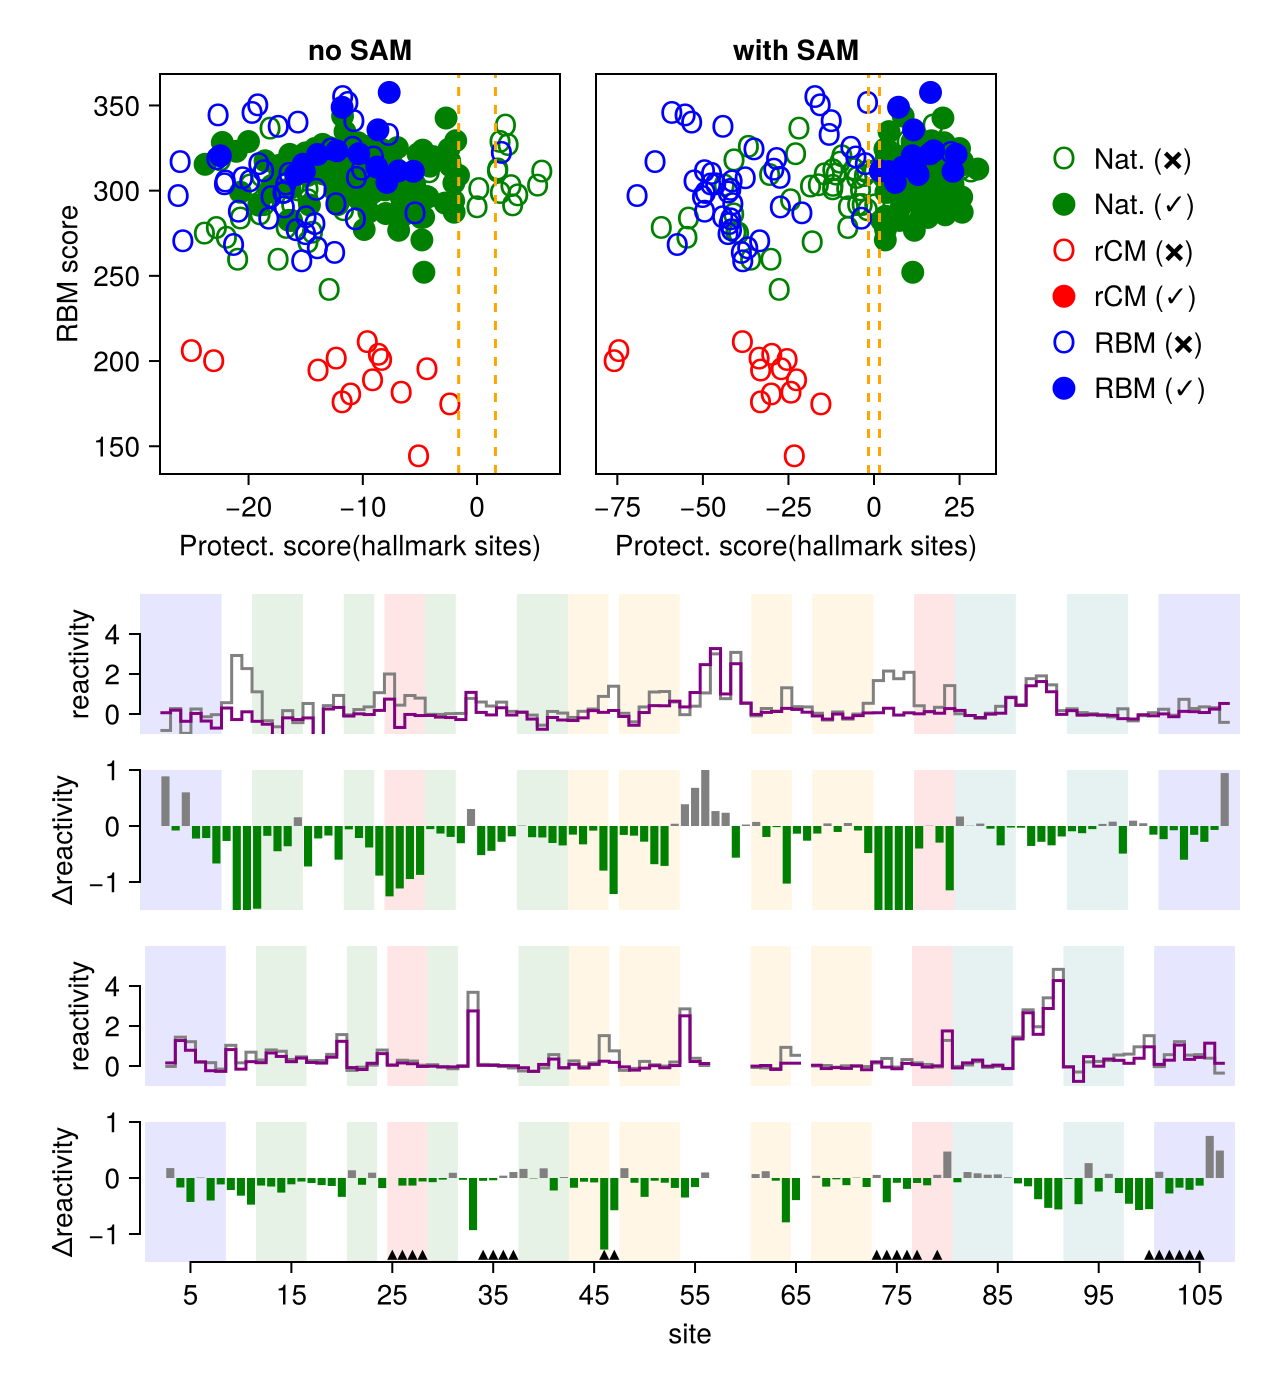

In [43]:
fig = Makie.Figure(; halign = :left)

ax = Makie.Axis(fig[1,1][1,1]; halign=:left, width=200, height=200, xlabel="Protect. score(hallmark sites)", ylabel="RBM score", title="no SAM", xgridvisible=false, ygridvisible=false)
#Makie.scatter!(ax, x_mg_rep0, -aptamer_rbm_energies, markersize=10, color=(:silver, 0.3), label="All probed")
Makie.scatter!(ax, x_mg_rep0[findall(_responds_sam_nop_rep0) ∩ nat_seqs], -aptamer_rbm_energies[findall(_responds_sam_nop_rep0) ∩ nat_seqs], markersize=15, color=:green, marker='O')
Makie.scatter!(ax, x_mg_rep0[findall(_responds_sam_yes_rep0) ∩ nat_seqs], -aptamer_rbm_energies[findall(_responds_sam_yes_rep0) ∩ nat_seqs], markersize=15, color=:green, marker='●')
Makie.scatter!(ax, x_mg_rep0[findall(_responds_sam_nop_rep0) ∩ inf_seqs], -aptamer_rbm_energies[findall(_responds_sam_nop_rep0) ∩ inf_seqs], markersize=15, color=:red, marker='O')
Makie.scatter!(ax, x_mg_rep0[findall(_responds_sam_yes_rep0) ∩ inf_seqs], -aptamer_rbm_energies[findall(_responds_sam_yes_rep0) ∩ inf_seqs], markersize=15, color=:red, marker='●')
Makie.scatter!(ax, x_mg_rep0[findall(_responds_sam_nop_rep0) ∩ rbm_seqs], -aptamer_rbm_energies[findall(_responds_sam_nop_rep0) ∩ rbm_seqs], markersize=15, color=:blue, marker='O')
Makie.scatter!(ax, x_mg_rep0[findall(_responds_sam_yes_rep0) ∩ rbm_seqs], -aptamer_rbm_energies[findall(_responds_sam_yes_rep0) ∩ rbm_seqs], markersize=15, color=:blue, marker='●')
Makie.vlines!(ax, [-_thresh, _thresh], linestyle=:dash, color=:orange)

ax = Makie.Axis(fig[1,1][1,2]; halign=:left, width=200, height=200, xlabel="Protect. score(hallmark sites)", ylabel="RBM score", title="with SAM", xgridvisible=false, ygridvisible=false)
#Makie.scatter!(ax, x_sam_rep0, -aptamer_rbm_energies, markersize=10, color=(:gray, 0.5), label="All probed")
plt1 = Makie.scatter!(ax, x_sam_rep0[findall(_responds_sam_nop_rep0) ∩ nat_seqs], -aptamer_rbm_energies[findall(_responds_sam_nop_rep0) ∩ nat_seqs], markersize=15, color=:green, marker='O', label="Nat. (❌)")
plt2 = Makie.scatter!(ax, x_sam_rep0[findall(_responds_sam_yes_rep0) ∩ nat_seqs], -aptamer_rbm_energies[findall(_responds_sam_yes_rep0) ∩ nat_seqs], markersize=15, color=:green, marker='●', label="Nat. (✓)")
plt3 = Makie.scatter!(ax, x_sam_rep0[findall(_responds_sam_nop_rep0) ∩ inf_seqs], -aptamer_rbm_energies[findall(_responds_sam_nop_rep0) ∩ inf_seqs], markersize=15, color=:red, marker='O', label="CM (❌)")
plt4 = Makie.scatter!(ax, x_sam_rep0[findall(_responds_sam_yes_rep0) ∩ inf_seqs], -aptamer_rbm_energies[findall(_responds_sam_yes_rep0) ∩ inf_seqs], markersize=15, color=:red, marker='●', label="CM (✓)")
plt5 = Makie.scatter!(ax, x_sam_rep0[findall(_responds_sam_nop_rep0) ∩ rbm_seqs], -aptamer_rbm_energies[findall(_responds_sam_nop_rep0) ∩ rbm_seqs], markersize=15, color=:blue, marker='O', label="RBM (❌)")
plt6 = Makie.scatter!(ax, x_sam_rep0[findall(_responds_sam_yes_rep0) ∩ rbm_seqs], -aptamer_rbm_energies[findall(_responds_sam_yes_rep0) ∩ rbm_seqs], markersize=15, color=:blue, marker='●', label="RBM (✓)")
Makie.vlines!(ax, [-_thresh, _thresh], linestyle=:dash, color=:orange)
#Makie.xlims!(ax, -78, 35)
Makie.hideydecorations!(ax)
#Makie.axislegend(ax, position=:rt, framevisible=false)
Makie.Legend(fig[1,1][1,3],
    [plt1, plt2, plt3, plt4, plt5, plt6],
    ["Nat. (❌)", "Nat. (✓)", "rCM (❌)", "rCM (✓)", "RBM (❌)", "RBM (✓)"],
    framevisible=false
)

# _dummy_ax = Makie.Axis(fig[1,2], width=400, height=300, xgridvisible=false, ygridvisible=false) # placeholder for the table
# Makie.hidexdecorations!(_dummy_ax)
# Makie.hideydecorations!(_dummy_ax)
# Makie.hidespines!(_dummy_ax, :t, :b, :l, :r)

n_ex_rbm = 299 # rbm example, switcher
#n_ex_nat = 112 # natural example, responsive but not switcher
n_ex_nat = 101 # natural example, responsive but not switcher

_width = 550
_height = 70

_R_sam = shape_data_all_merged.shape_reactivities[:, n_ex_rbm, conds_SAM_all_merged[1]]
_R_mg = shape_data_all_merged.shape_reactivities[:, n_ex_rbm, only(conds_Mg_all_merged)]

ax_react_1 = Makie.Axis(fig[2,1][1,1], width=_width, height=_height, xticks=5:10:108, ylabel="reactivity", xgridvisible=false, ygridvisible=false, yticks=0:2:5, ytrimspine=true)
for (x0, xf, color, alpha) = struct_bands
    Makie.vspan!(ax_react_1, x0, xf; color=(color, alpha))
end
Makie.stairs!(ax_react_1, 1:108, _R_mg, color=:gray, step=:center)
Makie.stairs!(ax_react_1, 1:108, _R_sam, color=:purple, step=:center)
Makie.xlims!(ax_react_1, 0.5, 108.5)
Makie.ylims!(ax_react_1, -1, 4)
Makie.hidespines!(ax_react_1, :t, :r, :b)
Makie.hidexdecorations!(ax_react_1)

ax_diff_1 = Makie.Axis(fig[2,1][2,1]; width=_width, height=_height, xticks=5:10:108, xlabel="site", ylabel="Δreactivity", xgridvisible=false, ygridvisible=false, xtrimspine=true, ytrimspine=true, yticks=-2:2)
for (x0, xf, color, alpha) = struct_bands
    Makie.vspan!(ax_diff_1, x0, xf; color=(color, alpha))
end
Makie.barplot!(ax_diff_1, 1:108, _R_sam - _R_mg, color=ifelse.(_R_sam - _R_mg .< 0, :green, :gray))
Makie.xlims!(ax_diff_1, 0.5, 108.5)
Makie.ylims!(ax_diff_1, -1.5, 1.5)
Makie.hidespines!(ax_diff_1, :t, :b, :r)
Makie.hidexdecorations!(ax_diff_1)

_R_sam = shape_data_all_merged.shape_reactivities[:, n_ex_nat, conds_SAM_all_merged[1]]
_R_mg = shape_data_all_merged.shape_reactivities[:, n_ex_nat, only(conds_Mg_all_merged)]

ax_react_2 = Makie.Axis(fig[2,1][3,1], width=_width, height=_height, xticks=10:10:108, ylabel="reactivity", xgridvisible=false, ygridvisible=false, yticks=0:2:5, ytrimspine=true)
for (x0, xf, color, alpha) = struct_bands
    Makie.vspan!(ax_react_2, x0, xf; color=(color, alpha))
end
Makie.stairs!(ax_react_2, 1:108, _R_mg, color=:gray, step=:center)
Makie.stairs!(ax_react_2, 1:108, _R_sam, color=:purple, step=:center)
Makie.xlims!(ax_react_2, 0.5, 108.5)
Makie.ylims!(ax_react_2, -1, 6)
Makie.hidespines!(ax_react_2, :t, :r, :b)
Makie.hidexdecorations!(ax_react_2)
#Makie.hideydecorations!(ax_react_2)

ax_diff_2 = Makie.Axis(fig[2,1][4,1]; width=_width, height=_height, xticks=5:10:108, xlabel="site", ylabel="Δreactivity", xgridvisible=false, ygridvisible=false, xtrimspine=true, ytrimspine=true, yticks=-2:2)
for (x0, xf, color, alpha) = struct_bands
    Makie.vspan!(ax_diff_2, x0, xf; color=(color, alpha))
end
Makie.barplot!(ax_diff_2, 1:108, _R_sam - _R_mg, color=ifelse.(_R_sam - _R_mg .< 0, :green, :gray))
Makie.scatter!(ax_diff_2, _sites, -1.4one.(_sites), markersize=7, color=:black, marker=:utriangle)
Makie.xlims!(ax_diff_2, 0, 109)
Makie.ylims!(ax_diff_2, -1.5, 1)
Makie.hidespines!(ax_diff_2, :t, :r)
#Makie.hideydecorations!(ax_diff_2)

# Makie.scatter!(ax_diff_1, _sites, one.(_sites), color=:blue, markersize=5)
# Makie.scatter!(ax_diff_2, _sites, one.(_sites), color=:blue, markersize=5)

Makie.linkxaxes!(ax_react_1, ax_diff_1)
Makie.linkxaxes!(ax_react_2, ax_diff_2)
Makie.linkyaxes!(ax_react_1, ax_react_2)
Makie.linkyaxes!(ax_diff_1, ax_diff_2)

Makie.resize_to_layout!(fig)
Makie.save("Figures/SAM response Repl0 v2.pdf", fig)
fig

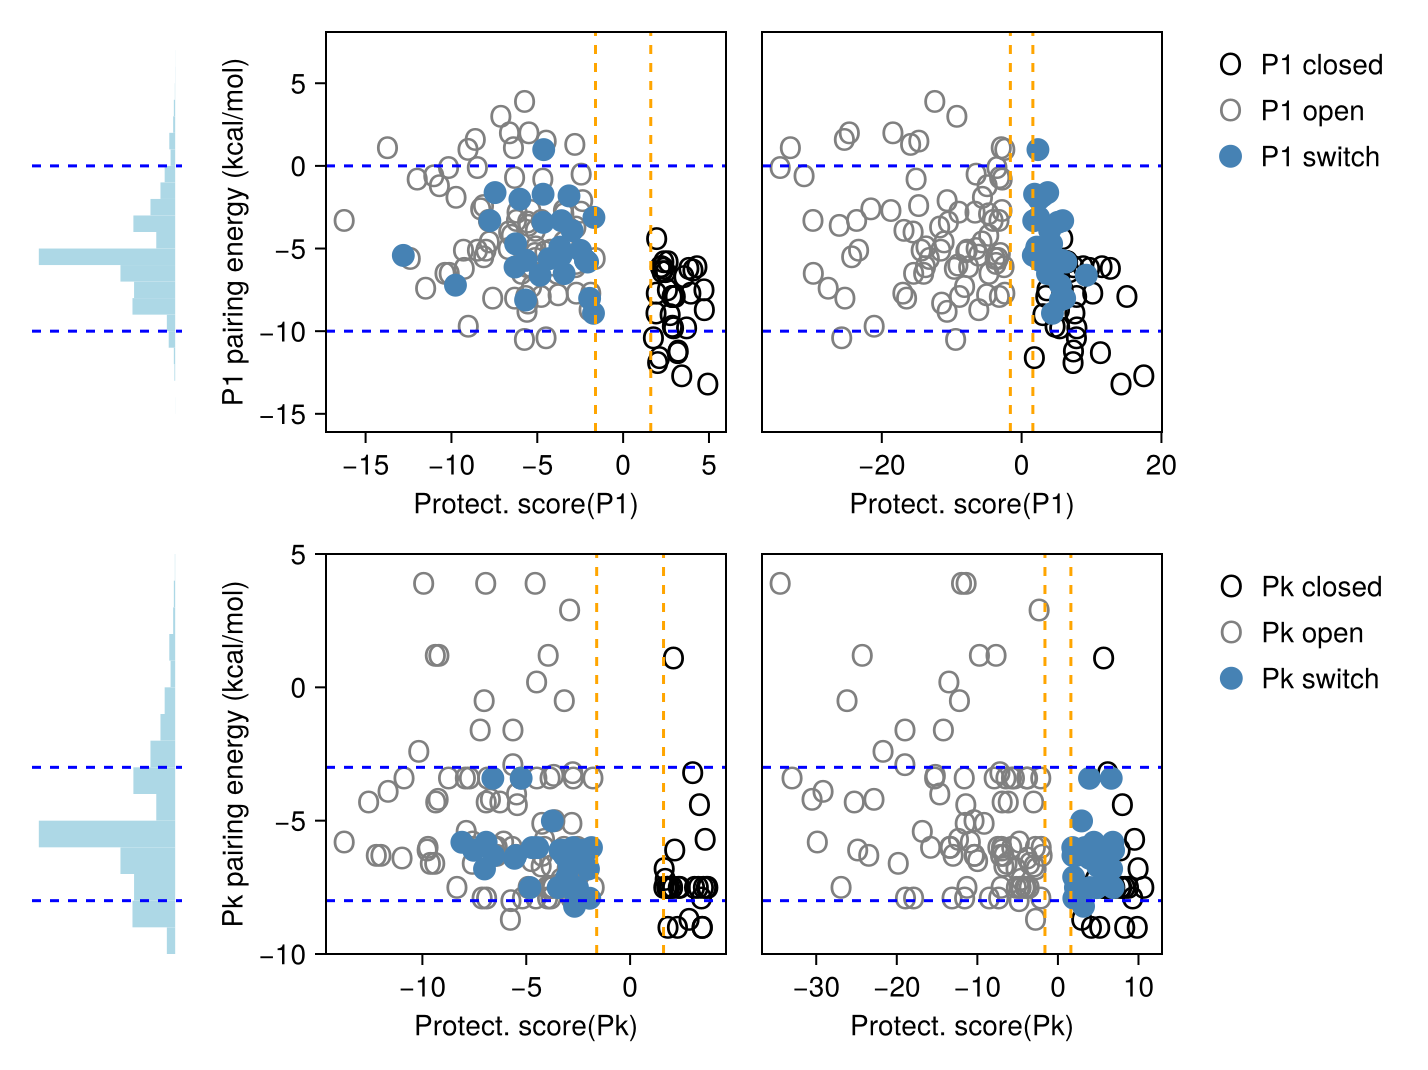

In [36]:
fig = Makie.Figure(; halign = :left)

_sz = 200

x_mg_p1 = nansum(shape_stats_rep0.shape_log_odds[p1_pos, :, conds_mg_rep0]; dim=(1,3))
x_sam_p1 = nansum(shape_stats_rep0.shape_log_odds[p1_pos, :, conds_sam_rep0]; dim=(1,3))

# responsive to SAM
_resp_sam_P1 = (x_mg_p1 .< -_thresh) .& (x_sam_p1 .> _thresh)
_stuck_open_P1 = (x_mg_p1 .< -_thresh) .& (x_sam_p1 .< -_thresh)
_stuck_closed_P1 = (x_mg_p1 .> _thresh) .& (x_sam_p1 .> _thresh)

_e_p1_bands = [-10, 0]

ax_rbm_hist = Makie.Axis(fig[1,1]; halign=:left, width=75, height=_sz, yticks=-15:5:5, xticks=[-0.2, 0, 0.2], xgridvisible=false, ygridvisible=false, xtrimspine=true, ytrimspine=true)
Makie.hist!(ax_rbm_hist, Vienna_energies_P1_RBM_samples, color=:lightblue, normalization=:pdf, bins=-15:1:7, direction=:x, scale_to=-1)
Makie.hlines!(ax_rbm_hist, _e_p1_bands, color=:blue, linestyle=:dash)
Makie.hidespines!(ax_rbm_hist, :t, :r, :l, :b)
Makie.hidexdecorations!(ax_rbm_hist)
Makie.hideydecorations!(ax_rbm_hist)

ax_mg = Makie.Axis(fig[1,2]; halign=:left, width=_sz, height=_sz, xlabel="Protect. score(P1)", ylabel="P1 pairing energy (kcal/mol)", xgridvisible=false, ygridvisible=false)
#Makie.scatter!(ax, nansum(shape_stats_rep0.shape_log_odds[p1_pos, :, conds_mg_rep0]; dim=(1,3)), Vienna_energies_P1, color=(:gray, 0.5), markersize=15)
plt1 = Makie.scatter!(ax_mg, nansum(shape_stats_rep0.shape_log_odds[p1_pos, _stuck_closed_P1, conds_mg_rep0]; dim=(1,3)), Vienna_energies_P1[_stuck_closed_P1], color=:black, markersize=15, label="P1 closed", marker='O')
plt2 = Makie.scatter!(ax_mg, nansum(shape_stats_rep0.shape_log_odds[p1_pos, _stuck_open_P1, conds_mg_rep0]; dim=(1,3)), Vienna_energies_P1[_stuck_open_P1], color=:gray, markersize=15, label="P1 open", marker='O')
plt3 = Makie.scatter!(ax_mg, nansum(shape_stats_rep0.shape_log_odds[p1_pos, _resp_sam_P1, conds_mg_rep0]; dim=(1,3)), Vienna_energies_P1[_resp_sam_P1], color=:steelblue, markersize=15, label="P1 switch", marker='●')
Makie.vlines!(ax_mg, [-_thresh, _thresh], linestyle=:dash, color=:orange)
Makie.hlines!(ax_mg, _e_p1_bands, color=:blue, linestyle=:dash)
Makie.Legend(fig[1,4], [plt1, plt2, plt3], ["P1 closed", "P1 open", "P1 switch"], framevisible=false, valign=:top)

ax_sam = Makie.Axis(fig[1,3]; halign=:left, width=_sz, height=_sz, xlabel="Protect. score(P1)", ylabel="P1 pairing energy (kcal/mol)", xgridvisible=false, ygridvisible=false)
#Makie.scatter!(ax, nansum(shape_stats_rep0.shape_log_odds[p1_pos, :, conds_sam_rep0]; dim=(1,3)), Vienna_energies_P1, color=(:gray, 0.5),  markersize=15)
Makie.scatter!(ax_sam, nansum(shape_stats_rep0.shape_log_odds[p1_pos, _stuck_closed_P1, conds_sam_rep0]; dim=(1,3)), Vienna_energies_P1[_stuck_closed_P1], color=:black, markersize=15, marker='O')
Makie.scatter!(ax_sam, nansum(shape_stats_rep0.shape_log_odds[p1_pos, _stuck_open_P1, conds_sam_rep0]; dim=(1,3)), Vienna_energies_P1[_stuck_open_P1], color=:gray, markersize=15, marker='O')
Makie.scatter!(ax_sam, nansum(shape_stats_rep0.shape_log_odds[p1_pos, _resp_sam_P1, conds_sam_rep0]; dim=(1,3)), Vienna_energies_P1[_resp_sam_P1], color=:steelblue, markersize=15, marker='●')
# Makie.hlines!(ax, nanmean(Vienna_energies_P1[_stuck_open]), color=:red, linewidth=2)
# Makie.hlines!(ax, nanmean(Vienna_energies_P1[_stuck_closed]), color=:green, linewidth=2)
# Makie.hlines!(ax, nanmean(Vienna_energies_P1[_resp_sam]), color=:blue, linewidth=2)
#nanmean(Vienna_energies_P1[_resp_sam]), nanmean(Vienna_energies_P1[_stuck_closed])
Makie.vlines!(ax_sam, [-_thresh, _thresh], linestyle=:dash, color=:orange)
Makie.hlines!(ax_sam, _e_p1_bands, color=:blue, linestyle=:dash)
Makie.hideydecorations!(ax_sam)

Makie.linkyaxes!(ax_rbm_hist, ax_mg, ax_sam)


x_mg_pk = nansum(shape_stats_rep0.shape_log_odds[pk_pos, :, conds_mg_rep0]; dim=(1,3))
x_sam_pk = nansum(shape_stats_rep0.shape_log_odds[pk_pos, :, conds_sam_rep0]; dim=(1,3))

# responsive to SAM
_resp_sam_Pk = (x_mg_pk .< -_thresh) .& (x_sam_pk .> _thresh)
_stuck_open_Pk = (x_mg_pk .< -_thresh) .& (x_sam_pk .< -_thresh)
_stuck_closed_Pk = (x_mg_pk .> _thresh) .& (x_sam_pk .> _thresh)

_e_pk_bands = [-8, -3]


ax_rbm_hist = Makie.Axis(fig[2,1]; halign=:left, width=75, height=_sz, yticks=-15:5:5, xticks=[-0.2, 0, 0.2], xgridvisible=false, ygridvisible=false, xtrimspine=true, ytrimspine=true)
Makie.hist!(ax_rbm_hist, Vienna_energies_P1_RBM_samples, color=:lightblue, normalization=:pdf, bins=-15:1:7, direction=:x, scale_to=-1)
Makie.hlines!(ax_rbm_hist, _e_pk_bands, color=:blue, linestyle=:dash)
Makie.hidespines!(ax_rbm_hist, :t, :b, :r, :l)
Makie.hidexdecorations!(ax_rbm_hist)
Makie.hideydecorations!(ax_rbm_hist)

ax_mg = Makie.Axis(fig[2,2]; halign=:left, width=_sz, height=_sz, xlabel="Protect. score(Pk)", ylabel="Pk pairing energy (kcal/mol)", xgridvisible=false, ygridvisible=false)
plt1 = Makie.scatter!(ax_mg, nansum(shape_stats_rep0.shape_log_odds[pk_pos, _stuck_closed_Pk, conds_mg_rep0]; dim=(1,3)), Vienna_energies_Pk_RNAeval[_stuck_closed_Pk], color=:black, markersize=15, label="Pk closed", marker='O')
plt2 = Makie.scatter!(ax_mg, nansum(shape_stats_rep0.shape_log_odds[pk_pos, _stuck_open_Pk, conds_mg_rep0]; dim=(1,3)), Vienna_energies_Pk_RNAeval[_stuck_open_Pk], color=:gray, markersize=15, label="Pk open", marker='O')
plt3 = Makie.scatter!(ax_mg, nansum(shape_stats_rep0.shape_log_odds[pk_pos, _resp_sam_Pk, conds_mg_rep0]; dim=(1,3)), Vienna_energies_Pk_RNAeval[_resp_sam_Pk], color=:steelblue, markersize=15, label="Pk switch", marker='●')
Makie.vlines!(ax_mg, [-_thresh, _thresh], linestyle=:dash, color=:orange)
Makie.hlines!(ax_mg, _e_pk_bands, color=:blue, linestyle=:dash)
Makie.Legend(fig[2,4], [plt1, plt2, plt3], ["Pk closed", "Pk open", "Pk switch"], framevisible=false, valign=:top)

ax_sam = Makie.Axis(fig[2,3]; halign=:left, width=_sz, height=_sz, xlabel="Protect. score(Pk)", ylabel="Pk pairing energy (kcal/mol)", xgridvisible=false, ygridvisible=false)
Makie.scatter!(ax_sam, nansum(shape_stats_rep0.shape_log_odds[pk_pos, _stuck_closed_Pk, conds_sam_rep0]; dim=(1,3)), Vienna_energies_Pk_RNAeval[_stuck_closed_Pk], color=:black, markersize=15, marker='O')
Makie.scatter!(ax_sam, nansum(shape_stats_rep0.shape_log_odds[pk_pos, _stuck_open_Pk, conds_sam_rep0]; dim=(1,3)), Vienna_energies_Pk_RNAeval[_stuck_open_Pk], color=:gray, markersize=15, marker='O')
Makie.scatter!(ax_sam, nansum(shape_stats_rep0.shape_log_odds[pk_pos, _resp_sam_Pk, conds_sam_rep0]; dim=(1,3)), Vienna_energies_Pk_RNAeval[_resp_sam_Pk], color=:steelblue, markersize=15, marker='●')
Makie.vlines!(ax_sam, [-_thresh, _thresh], linestyle=:dash, color=:orange)
Makie.hlines!(ax_sam, _e_pk_bands, color=:blue, linestyle=:dash)
Makie.hideydecorations!(ax_sam)

Makie.ylims!(ax_mg, -10, 5)
Makie.ylims!(ax_sam, -10, 5)
Makie.linkyaxes!(ax_rbm_hist, ax_mg, ax_sam)


Makie.resize_to_layout!(fig)
Makie.save("Figures/SAM response Repl0 -- Vienna.pdf", fig)
fig